In [1]:
import numpy as np
import pandas as pd
import urllib.request
import requests
import re
from matplotlib import pyplot as plt
import seaborn as sns

# Traffic violations data

### Description of the police data columns

[POLICE TRAFFIC VIOLATION METADATA](https://www.politsei.ee/files/Anal%C3%BC%C3%BCs%20ja%20statistika/ppaavaandmeteseletuskiri.pdf?f3ca9bccf9)

In [2]:
data = pd.read_csv("liiklusjarelevalve_3.csv", encoding = "UTF-8", sep='\t')

In [3]:
police_data = data.copy()
police_data.head()

,JuhtumId,ToimKpv,ToimKell,ToimNadalapaev,Seadus,Paragrahv,ParagrahvTais,Loige,Punkt,RikutudOigusnorm,...,Lest_X,Lest_Y,SoidukLiik,SoidukRegRiik,SoidukMark,SoidukVlAasta,RikkujaSugu,RikkujaVanus,RikkujaElukoht,SyyteoLiik
0,9617cbde-1636-18d5-8326-a9a756483dba,2013-12-31,23:38,Teisipäev,Liiklusseadus,§ 242.,§ 242. Mootorsõiduki- või trammijuhi poolt lii...,lg. 1.,,LS § 76 lg. 1; § 73 lg. 1; § 106 lg. 3,...,6534000-6534499,473000-473499,SOIDUAUTO,EST,VOLKSWAGEN,1994,M,18-25,EST,VT
1,9617cc1a-1636-18d5-8326-a9a756483dba,2013-12-31,23:25,Teisipäev,Liiklusseadus,§ 227.,§ 227. Mootorsõidukijuhi poolt lubatud sõiduki...,lg. 2.,,LS § 15 lg. 1 p. 1,...,6577500-6577999,546500-546999,SOIDUAUTO,EST,VOLVO,2010,M,26-34,NaN,VT
2,9617c9cc-1636-18d5-8326-a9a756483dba,2013-12-31,23:20,Teisipäev,Liiklusseadus,§ 201.,"§ 201. Mootorsõiduki, maastikusõiduki või tram...",lg. 1.,,LS § 90 lg. 1 p. 1,...,6588500-6588999,685500-685999,TUNDMATU,EST,CITROEN,2008,M,18-25,NaN,VT
3,9617d20a-1636-18d5-8326-a9a756483dba,2013-12-31,23:20,Teisipäev,Liiklusseadus,§ 202.,"§ 202. Mootorsõiduki, maastikusõiduki või tram...",lg. 1.,,LS § 90 lg. 2,...,6588500-6588999,685500-685999,TUNDMATU,EST,CITROEN,2008,M,26-34,NaN,VT
4,9617d20a-1636-18d5-8326-a9a756483dba,2013-12-31,23:20,Teisipäev,Liiklusseadus,§ 225.,"§ 225. Joobes isiku mootorsõidukit, maastikusõ...",lg. 1.,,LS § 90 lg. 2,...,6588500-6588999,685500-685999,TUNDMATU,EST,CITROEN,2008,M,26-34,NaN,VT


## Pruning data by coordinates 

[Official Tartu map](https://www.tartu.ee/kaart/)<br>
The coordinates can be converted to GPS coordinates (longitude and latitude) in order to get a map in the full range of these coordinates.<br>
[Conversion of coordinates betwwen L-EST and GPS](https://www.maaamet.ee/rr/geo-lest/url/)

#### A smaller area with most of Tartu inside

GPS: 58.404933,26.799217 L-EST: 6477249.3690577,663596.12162501<br>
GPS: 58.340461,26.644670 L-EST: 6469707.6486631,654851.71159927

A corresponding map is at 'gmaps_tartu_smaller.png'.

In [4]:
# takes coordinate in form '668000-668499', separates the values as floats into a list [668000, 668499]
getLowHigh = lambda coords: list(map(float, coords.split('-')))

# takes lowHigh coordinate list [668000, 668499] and its bounds, checks if coord is out of bounds
coordNotInRange = lambda lowHigh, c_min, c_max : lowHigh[0] < c_min or lowHigh[1] > c_max

# takes lowHigh coordinate list [668000, 668499], calculates their average
getAvg = lambda lowHigh: round(sum(lowHigh) / len(lowHigh)) 

We will prune the data by a bound rectangle and find the average coordinates for those datapoints inside the rectangle.

In [60]:
lest_x, lest_y = list(police_data['Lest_X']), list(police_data['Lest_Y'])
avg_x, avg_y, xy_in_area = [], [], []

# boundaries
x_min, x_max = 6469500, 6477500
y_min, y_max = 654500, 663500
for xc, yc in zip(lest_x, lest_y):
    
    try: 
        low_high_X = getLowHigh(xc)
        low_high_Y = getLowHigh(yc)
    except: # if the cell is faulty, we will still need to continue without errors
        # these rows will be excluded
        xy_in_area.append(False)
        continue
    
    if coordNotInRange(low_high_X, x_min, x_max) or coordNotInRange(low_high_Y, y_min, y_max):
        xy_in_area.append(False)
    else:
        xy_in_area.append(True)
        
        # calculate average coordinates for all datapoints within boundaries
        avg_x.append(getAvg(low_high_X))
        avg_y.append(getAvg(low_high_Y))

In [61]:
tartu_data = police_data[xy_in_area] # filter the results to fit into chosen rectangle of coordinates
tartu_data = tartu_data[['JuhtumId', 'ToimKpv', 'ToimKell', 'Lest_X', 'Lest_Y']] # Columns selected for our project
tartu_data = tartu_data.reset_index().drop('index', axis = 1)
tartu_data['Avg_x'] = avg_x
tartu_data['Avg_y'] = avg_y

tartu_data.head()

,JuhtumId,ToimKpv,ToimKell,Lest_X,Lest_Y,Avg_x,Avg_y
0,9617ed94-1636-18d5-8326-a9a756483dba,2013-12-31,21:06,6475000-6475499,659000-659499,6475250,659250
1,9617e9de-1636-18d5-8326-a9a756483dba,2013-12-31,20:28,6475000-6475499,659000-659499,6475250,659250
2,9617ed3a-1636-18d5-8326-a9a756483dba,2013-12-31,19:19,6472000-6472499,656500-656999,6472250,656750
3,9617ec90-1636-18d5-8326-a9a756483dba,2013-12-31,14:19,6475000-6475499,659000-659499,6475250,659250
4,9617ebaa-1636-18d5-8326-a9a756483dba,2013-12-31,13:44,6475000-6475499,659000-659499,6475250,659250


# Weather data

## 2019 weather data (9000 rows)

In [7]:
w_d_web = 'http://meteo.physic.ut.ee/et/archive.php?do=data&begin%5Byear%5D=2019&begin%5Bmon%5D=11&begin%5Bmday%5D=4&end%5Byear%5D=2019&end%5Bmon%5D=12&end%5Bmday%5D=5&9=1&16=1&14=1&ok=+Esita+p%C3%A4ring+'

table = requests.get(w_d_web)

## 2012-2019 weather data

In [8]:
w_d_web = 'http://meteo.physic.ut.ee/et/archive.php?do=data&begin%5Byear%5D=2012&begin%5Bmon%5D=1&begin%5Bmday%5D=1&end%5Byear%5D=2019&end%5Bmon%5D=12&end%5Bmday%5D=8&9=1&16=1&14=1&ok=+Esita+p%C3%A4ring+'

table = requests.get(w_d_web)

## 2012 weather data (105210 rows)

In [9]:
w_d_web = 'http://meteo.physic.ut.ee/et/archive.php?do=data&begin%5Byear%5D=2012&begin%5Bmon%5D=1&begin%5Bmday%5D=1&end%5Byear%5D=2013&end%5Bmon%5D=1&end%5Bmday%5D=1&9=1&16=1&11=1&ok=+Esita+p%C3%A4ring+'

table = requests.get(w_d_web)

In [10]:
w_d_raw = []

for row in table:
    w_d_raw.append(row.decode('utf-8').split('\n')) # Removing all non-data characters (\n and b)

In [11]:
def striplist(l):
    return list(map(lambda s: s.strip(), l))

In [12]:
wd_list = []
wd_cols = striplist(w_d_raw[0][0].split(','))

wd_list.append(striplist(w_d_raw[0][1].split(',')))
i = 0
while i < len(w_d_raw)-1:
    if len(w_d_raw[i]) == 4:
        wd_list.append(striplist(w_d_raw[i][2].split(',')))
        wd_list.append(striplist((w_d_raw[i][3] + w_d_raw[i + 1][0]).split(',')))
    else:
        wd_list.append(striplist((w_d_raw[i][2] + w_d_raw[i + 1][0]).split(',')))
    wd_list.append(striplist(w_d_raw[i + 1][1].split(',')))
    i += 1

weather_df = pd.DataFrame(wd_list)[[0, 1, 2, 3]]
weather_df.columns = ['datetime', 'temp','prec','illuminance']
weather_df = weather_df[weather_df.temp != '']

In [13]:
print(weather_df.shape)
weather_df.head()

(105173, 4)


,datetime,temp,prec,illuminance
0,2012-01-01 00:00:00,-1.40256386952938,0,1596.32524005174
1,2012-01-01 00:05:00,-1.3072008201295098,0,1766.2777027866002
2,2012-01-01 00:10:00,-1.24774878404425,0,1537.72557855376
3,2012-01-01 00:15:00,-1.2859692273800398,0,1483.7225387054602
4,2012-01-01 00:20:00,-1.4057889884906098,0,1544.08768822554


# 5-minute, hourly and daily data

In [14]:
from datetime import datetime

Let's create hourly and daily averaged temperature, precipitation, irradiation flux and traffic violations amount to try and find correlations. 

### Weather data

In [15]:
timeformat = '%Y-%m-%d %H:%M:%S'

hours = []
dates = []
times = []
for t in weather_df.datetime:
    dt = datetime.strptime(t, timeformat)
    hours.append(dt.hour)
    dates.append(dt.date())
    times.append(dt.time())

weather_df['hour'] = hours
weather_df['date'] = dates
weather_df['time'] = times

weather_df = weather_df.drop(columns = ['datetime'])

In [16]:
weather_df.temp = list(map(float, weather_df.temp))
weather_df.prec = list(map(float, weather_df.prec))
weather_df.illuminance = list(map(float, weather_df.illuminance))
weather_df.hour = list(map(int, weather_df.hour))

In [17]:
dailymean_wd = weather_df.groupby(by = 'date').mean()
hourlymean_wd = weather_df.groupby(['date','hour'], as_index=False).mean()

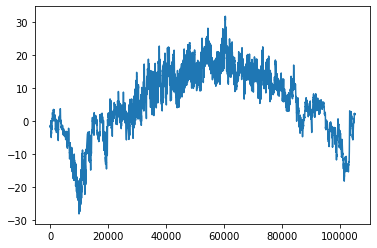

In [18]:
plt.plot(weather_df['temp'])

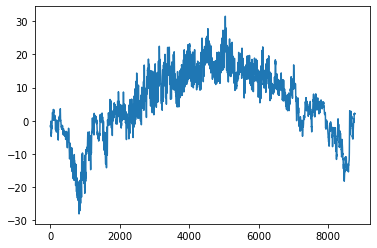

In [19]:
plt.plot(hourlymean_wd['temp'])

C:\Users\Karlm\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


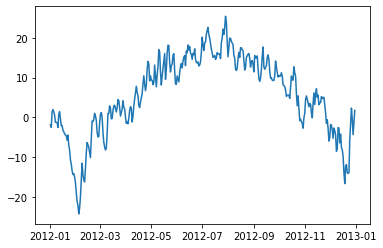

In [20]:
plt.plot(dailymean_wd['temp'])

### Police Data

In [21]:
police_df = tartu_data.copy()

In [22]:
timeformat = '%H:%M'

hours = []
minutes = []
times = []
for t in police_df.ToimKell:
    try:
        dt = datetime.strptime(t, timeformat) 
        dt = dt.replace(minute = dt.minute // 5 * 5) # 5 minuti kaupa
        hours.append(dt.hour)
        minutes.append(dt.minute)
        times.append(dt.time())
    except:
        hours.append(np.nan)
        minutes.append(np.nan)
        times.append(np.nan)
        continue
        # ignore

police_df['hour'] = hours
police_df['minute'] = minutes
police_df['time'] = times

In [23]:
police_df.head()

,JuhtumId,ToimKpv,ToimKell,Lest_X,Lest_Y,Avg_x,Avg_y,hour,minute,time
0,9617ed94-1636-18d5-8326-a9a756483dba,2013-12-31,21:06,6475000-6475499,659000-659499,6475250,659250,21.0,5.0,21:05:00
1,9617e9de-1636-18d5-8326-a9a756483dba,2013-12-31,20:28,6475000-6475499,659000-659499,6475250,659250,20.0,25.0,20:25:00
2,9617ed3a-1636-18d5-8326-a9a756483dba,2013-12-31,19:19,6472000-6472499,656500-656999,6472250,656750,19.0,15.0,19:15:00
3,9617ec90-1636-18d5-8326-a9a756483dba,2013-12-31,14:19,6475000-6475499,659000-659499,6475250,659250,14.0,15.0,14:15:00
4,9617ebaa-1636-18d5-8326-a9a756483dba,2013-12-31,13:44,6475000-6475499,659000-659499,6475250,659250,13.0,40.0,13:40:00


In [24]:
# violations per 1 day interval
dailymean_pd = police_df.groupby(['ToimKpv']).count()['JuhtumId']

# violations per 1 hour interval
hourlymean_pd = police_df.groupby(['ToimKpv','hour']).count()['JuhtumId']

# violations per 5 minute interval
minutelymean_pd = police_df.groupby(['ToimKpv', 'hour', 'minute']).count()['JuhtumId']

## Combine violation count in 5 minute intervals with weather data

In [25]:
comb_df = weather_df[['time', 'date', 'hour', 'temp', 'illuminance']]
timeformat = '%Y-%m-%d'

v_counts = []
for index, row in comb_df.iterrows():
    try:
        v_counts.append(minutelymean_pd[(row.date.strftime(timeformat), row.hour, row.time.minute)])
    except:
        v_counts.append(0)

comb_df['violations'] = v_counts

In [26]:
hourlymean_cd = comb_df.groupby(['date','hour'], as_index=False).sum()
dailymean_cd = comb_df.groupby(['date']).sum()

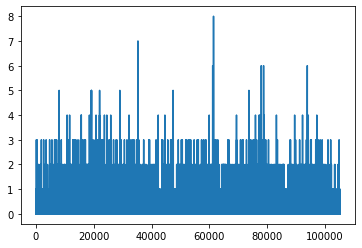

In [27]:
plt.plot(comb_df['violations'])

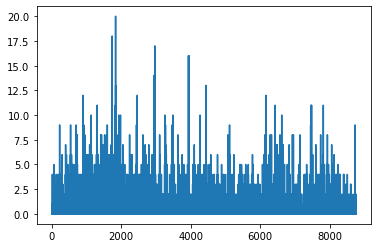

In [28]:
plt.plot(hourlymean_cd['violations'])

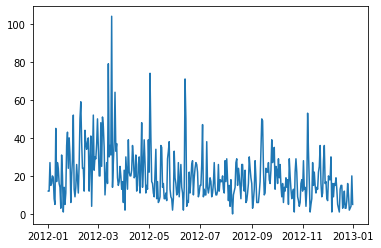

In [29]:
plt.plot(dailymean_cd['violations'])

In [30]:
hourlymean_cd.to_csv('weathertimeviolations_hourlymean.csv', index = False)

In [31]:
dailymean_cd.to_csv('weathertimeviolations_dailymean.csv', index = False)

In [32]:
comb_df.to_csv('weathertimeviolations.csv', index = False)

# Modelling

Read the latest data from file to separate data manipulation flow from the modelling tasks flow.

In [33]:
weatherviolations_minutely = pd.read_csv('weathertimeviolations.csv')
weatherviolations_hourly = pd.read_csv('weathertimeviolations_hourlymean.csv')
weatherviolations_daily = pd.read_csv('weathertimeviolations_dailymean.csv')

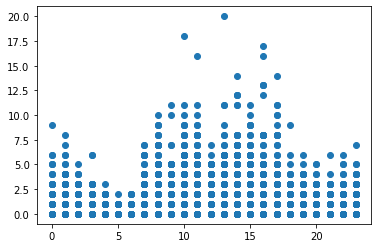

In [34]:
plt.scatter(weatherviolations_hourly['hour'], weatherviolations_hourly['violations'])

**More violations during the day**

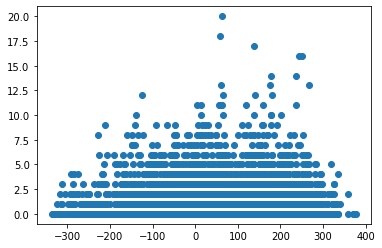

In [35]:
plt.scatter(weatherviolations_hourly['temp'], weatherviolations_hourly['violations'])

**More violations at 5-15 oC temperature?**

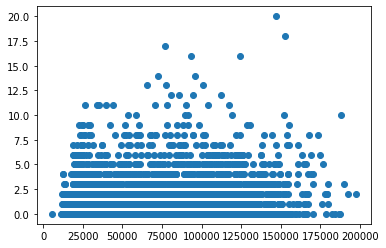

In [36]:
plt.scatter(weatherviolations_hourly['illuminance'], weatherviolations_hourly['violations'])

**More violations at low luminance?**

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_val, y_train, y_val = train_test_split(hourlymean_cd[['hour', 'temp', 'illuminance']], hourlymean_cd['violations'], test_size=0.3, random_state = 1)

In [39]:
rf1 = RandomForestRegressor(n_estimators = 200, random_state = 1).fit(X_train, y_train)

In [40]:
rf1.score(X_val, y_val)

0.04843623629260452

In [41]:
rf2 = RandomForestRegressor(n_estimators = 200,
                            random_state = 1,
                           min_samples_leaf = 4).fit(X_train, y_train)

In [42]:
rf2.score(X_val, y_val)

0.11321852580946346

# Heatmap intervals and classification

In [64]:
# violations for whole time range in specific coordinate box
viocount_percoord = police_df.groupby(['Avg_x', 'Avg_y']).count()['JuhtumId']

In [107]:
# currently required to input x as XXXXY00, y as XXXY00, where Y is 0 or 5
def create_heatmap_data(x_start = 6469500, x_end = 6477500, y_start = 654500, y_end = 663500, verbose = False):
    # largest boundaries: x:6464500 .. 6478500, y:645500 .. 668500
    x_min, x_max = 6469500, 6477500
    y_min, y_max = 654500, 663500
    
    # if input is out of range
    x_start, x_end = max(x_start, x_min), min(x_end, x_max)
    y_start, y_end = max(y_start, y_min), min(y_end, y_max)
    
    # how many squares in each direction
    x_len = int((x_end - x_start) / 500)
    y_len = int((y_end - y_start) / 500)

    # avg_X := XXXXY50, where Y is 2 or 7
    # avg_Y := XXXY50, where Y is 2 or 7

    # generate all Avg_X from 6464750 to 6478750
    avg_xs = range(x_start + 250, x_end + 250, 500)

    # generate all Avg_Y from 645750 to 668750
    avg_ys = range(y_start + 250, y_end + 250, 500)

    # create 2d-array for the heatmap
    heatmap_data = np.zeros((x_len, y_len))

    for x_idx, x in enumerate(reversed(avg_xs)):
        for y_idx, y in enumerate(avg_ys): # reverse ys to start at top left corner
            try:
                heatmap_data[x_idx][y_idx] = viocount_percoord[(x, y)]
                if verbose:
                    print('At idx ',(x_idx, y_idx),', At coord ',(x, y),": ", viocount_percoord[(x, y)], ' violations')
            except:
                heatmap_data[x_idx][y_idx] = 0

    return heatmap_data

In [81]:
from matplotlib import image, cm
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns 
import numpy.random as random
sns.set(font_scale=1.4)

In [116]:
def show_heatmap(hmap_data, image_name, hmap_filename_prefix = ''):
    
    x_min, x_max = 6469500, 6477500
    y_min, y_max = 654500, 663500
    
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    # aspect ratio (+8 for the scale)
    plt.rcParams['figure.figsize'] = (40 + 10), round(40 * (x_max - x_min) / (y_max - y_min))
    
    wd = plt.cm.winter._segmentdata
    wd['alpha'] = ((0.0, 0.0, 0.3), 
               (0.3, 0.3, 1.0),
               (1.0, 1.0, 1.0))
    al_winter = LinearSegmentedColormap('AlphaWinter', wd) 

    # get the map image as array to be able to plot it 
    map_img = image.imread(image_name)

    hmax = sns.heatmap(hmap_data,
                cmap = al_winter,
                alpha = 0.4, # whole heatmap is translucent
                annot = False, # display violation counts
                zorder = 2,
                fmt = 'g', # change number formatting to not use scientific
                )
    
    hmax.imshow(map_img,
              aspect = hmax.get_aspect(),
              extent = hmax.get_xlim() + hmax.get_ylim(),
              zorder = 1) #put the map under the heatmap
    
    hmax.get_figure().savefig([hmap_filename_prefix] + "_hmap_" + image_name)

    plt.show()

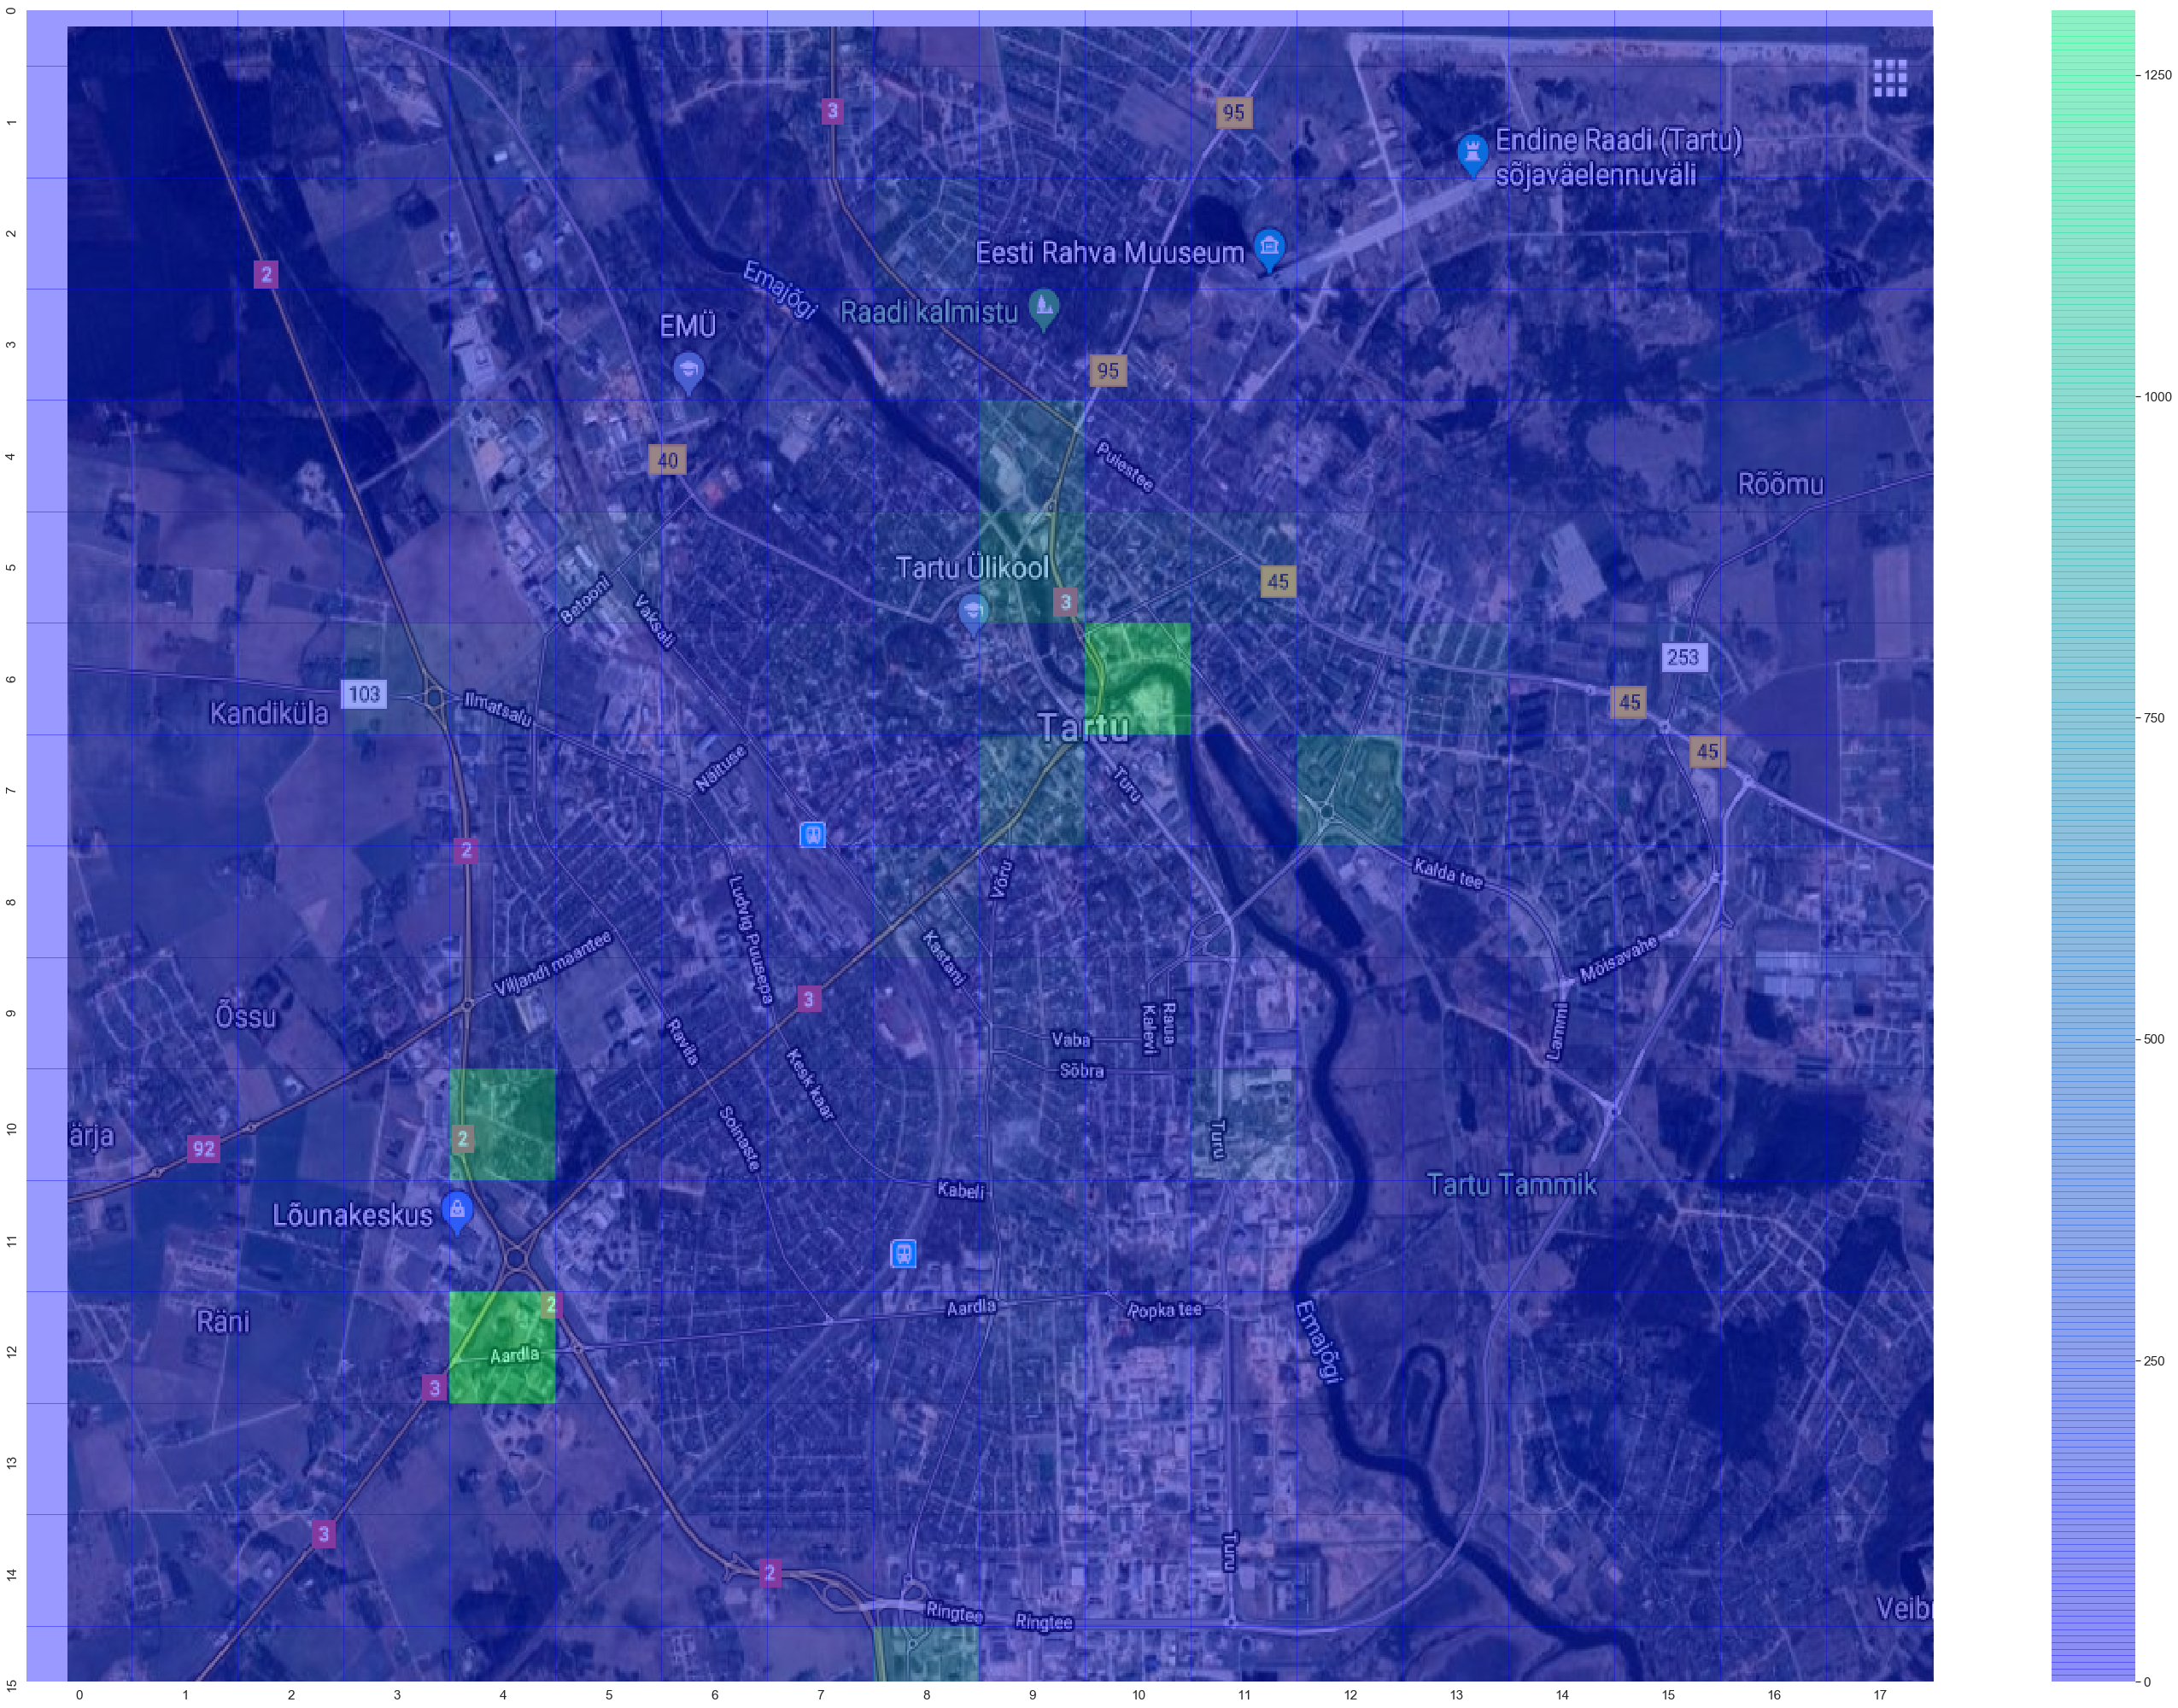

In [117]:
hmap = create_heatmap_data()
show_heatmap(hmap_data = hmap, 
             image_name = 'gmaps_tartu_smaller.png')

In [48]:
x_c = np.zeros((8, 1), dtype = int)
y_c = np.zeros((1, 8), dtype = int)
c = np.zeros((8, 8), dtype = int)

In [49]:
def interval(x_start, y_start, interval):

    k = 1
    while k <= len(x_c):
        x_c[k-1][0] = x_start + (interval*k)
        y_c[0][k-1] = y_start + (interval*k)
        k += 1

In [50]:
def grid_loc(a, b, l1, l2): # l1 and l2 are to determain the coordinates position in the made grid
    n = 0
    l = [0, 0]
    while n < len(l1):
        if a < l1[n][0]: # a is the x-coordinate
            l[0] = n
            break

        n += 1

    z = 0
    
    while z < len(l1):
        if b < l2[0][z]: # b is the y-coordinate
            l[1] = z
            break

        z += 1
        
    return l

In [51]:
x0 = 6470000
y0 = 656000
inter = 1000

interval(x0, y0, inter)

In [52]:
loc = police_df[['Lest_X', 'Lest_Y']]
len_loc = 0
grid = []

while len_loc < len(loc):
    grid.append(grid_loc(loc.iloc[len_loc][0], loc.iloc[len_loc][1], x_c, y_c))   
    len_loc += 1

TypeError: '>' not supported between instances of 'numpy.ndarray' and 'str'

In [ ]:
for el in grid:
    c[el[0]][el[1]] += 1

In [ ]:
n = 7
co = []

while n >= 0:
    co.append(list(c[n]))
    n -= 1

In [ ]:
plt.subplots(figsize = (12, 10))
hm = sns.heatmap(co, xticklabels = False, yticklabels = False, cmap = 'summer_r')

In [ ]:
pic = hm.get_figure()
#pic.savefig('heatmap_2012_terrain_r.png')